<a href="https://colab.research.google.com/github/imstaHub/hanghae99/blob/master/week2_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week2 Adevanced Homework

In [1]:
!pip install datasets sacremoses
##sacremoses는 영어를 위한 tokenizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 기존 코드

In [2]:
import numpy as np

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        # preds = torch.argmax(preds, dim=-1)
        preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] Multi Head Attention으로 변경

- n_heads 인자 추가 및 shape 조정
- softmax 이후 reshape을 통해 기존 shape으로 변경

In [46]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        if(d_model%n_heads==0):
            self.n_heads = n_heads
        else:
            raise Exception("please reset n_heads or d_model")


        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        batch_size, max_len, _ = x.shape
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        # reshape
        # (B) x max_len x d_model -> (B) x max_len x n_heads x d_model' -> (B) x n_heads x max_len x d_model'
        q = q.reshape(batch_size, max_len, self.n_heads, int(self.d_model/self.n_heads)).transpose(1,2)
        k = k.reshape(batch_size, max_len, self.n_heads, int(self.d_model/self.n_heads)).transpose(1,2)
        v = v.reshape(batch_size, max_len, self.n_heads, int(self.d_model/self.n_heads)).transpose(1,2)

        # shape -> (B) x n_heads x max_len x max_len
        score = torch.matmul(q, k.transpose(-1, -2))
        score = score / sqrt(self.d_model/self.n_heads)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        # (B) x n_heads x max_len x d_model'
        result = torch.matmul(score, v)
        # 기존 차원으로 변경
        # (B) x n_heads x max_len x d_model' -> (B) x max_len x n_heads x d_model' -> (B) x max_len x d_model
        result = result.transpose(1,2).reshape(batch_size, max_len, self.d_model)
        result = self.dense(result)

        return result

## [MY CODE] SelfAttention을 MultiHeadAttention으로 변경 및 forward 함수 변경

In [40]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff
        self.n_heads = n_heads

        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)
        self.ffn = nn.Sequential(
          nn.Linear(d_model, dff),
          nn.ReLU(),
          nn.Linear(dff, d_model)
        )

        self.dropout = nn.Dropout(0.1)
        self.layerNorm = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        x1 = self.mha(x, mask)
        x1 = self.dropout(x1)
        x1 = self.layerNorm(x1 + x)

        x2 = self.ffn(x1)
        x2 = self.dropout(x2)
        x2 = self.layerNorm(x2 + x1)

        return x2

In [41]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


## [MY CODE] model 작성, layer=5, n_heads=4

In [42]:
from torch.optim import Adam

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
        self.classification = nn.Linear(d_model, 1)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
          x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)

        return x

# layer=5, n_heads=4
model = TextClassifier(len(tokenizer), 32, 5, 32, 4)
model = model.to('cuda')

loss_fn = nn.BCEWithLogitsLoss()

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [43]:
model

TextClassifier(
  (embedding): Embedding(30522, 32)
  (layers): ModuleList(
    (0-4): 5 x TransformerLayer(
      (mha): MultiHeadAttention(
        (wq): Linear(in_features=32, out_features=32, bias=True)
        (wk): Linear(in_features=32, out_features=32, bias=True)
        (wv): Linear(in_features=32, out_features=32, bias=True)
        (dense): Linear(in_features=32, out_features=32, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (ffn): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (layerNorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (classification): Linear(in_features=32, out_features=1, bias=True)
)

## [MY CODE] 학습 진행

In [44]:
n_epochs = 50

train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

Epoch   0 | Train Loss: 227.85167640447617
=========> Train acc: 0.787 | Test acc: 0.760
Epoch   1 | Train Loss: 169.6525503396988
=========> Train acc: 0.858 | Test acc: 0.805
Epoch   2 | Train Loss: 137.43307238817215
=========> Train acc: 0.886 | Test acc: 0.816
Epoch   3 | Train Loss: 112.50839547812939
=========> Train acc: 0.887 | Test acc: 0.806
Epoch   4 | Train Loss: 92.11406218260527
=========> Train acc: 0.946 | Test acc: 0.828
Epoch   5 | Train Loss: 75.20427997782826
=========> Train acc: 0.962 | Test acc: 0.826
Epoch   6 | Train Loss: 57.96148380637169
=========> Train acc: 0.973 | Test acc: 0.823
Epoch   7 | Train Loss: 48.68171267770231
=========> Train acc: 0.981 | Test acc: 0.825
Epoch   8 | Train Loss: 38.16458117775619
=========> Train acc: 0.981 | Test acc: 0.817
Epoch   9 | Train Loss: 30.35750555805862
=========> Train acc: 0.988 | Test acc: 0.818
Epoch  10 | Train Loss: 26.964372005313635
=========> Train acc: 0.979 | Test acc: 0.808
Epoch  11 | Train Loss: 25.1

## [MY CODE] 학습 결과 비교 plot

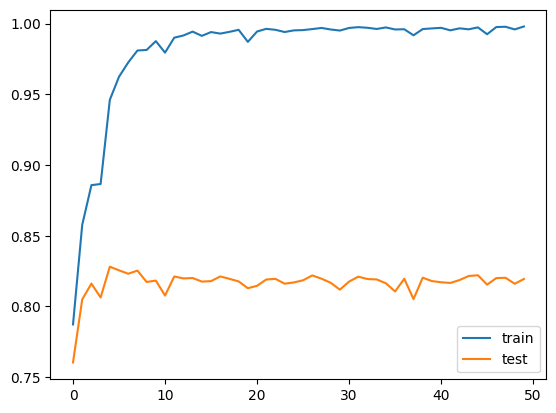

In [45]:
from matplotlib import pyplot as plt
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_acc_list, test_acc_list)

## [LOG] train이 정확도 99%, test가 80%이상으로 학습이 매우 잘 됨

## [MY CODE] shape 확인

In [52]:
from torch.optim import Adam

class TextClassifier2(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
        self.classification = nn.Linear(d_model, 1)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, None, :]
        print('x:', x.shape)
        print('mask:', mask.shape)
        raise
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
          x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)

        return x

# layer=5, n_heads=4
model2 = TextClassifier2(len(tokenizer), 32, 5, 32, 4)
model2 = model2.to('cuda')

loss_fn = nn.BCEWithLogitsLoss()

lr = 0.001
optimizer = Adam(model2.parameters(), lr=lr)

In [53]:
n_epochs = 1
for epoch in range(n_epochs):
    total_loss = 0.
    model2.train()
    for data in train_loader:
        model2.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model2(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

x: torch.Size([64, 400])
mask: torch.Size([64, 1, 1, 400])


RuntimeError: No active exception to reraise